# Gym Customer Analysis

Using K-Means clustering on https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset/data 


# Library Imports and Setup

In [ ]:
# Install the mxnet library required for certain functionalities in SageMaker
!pip install mxnet

#This is a fix for mxnet depenancy issues
import numpy as np
np.bool = np.bool_

# AWS SageMaker and Boto3
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.image_uris import retrieve
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.tuner import IntegerParameter, CategoricalParameter, HyperparameterTuner
from sagemaker.amazon.common import write_numpy_to_dense_tensor
from sagemaker.inputs import TrainingInput
import boto3
from botocore.exceptions import ClientError

# Data Manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Additional Libraries
import tarfile
import mxnet as mx
import datetime
import json
import time
from tabulate import tabulate

from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 151.1 MB/s eta 0:00:00a 0:00:01


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/28/25 13:50:24] INFO     Found credentials from IAM Role:                                   ]8;id=616501;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=819517;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[03/28/25 13:50:38] WARNING  Matplotlib is building the font cache; this may take a moment.    ]8;id=213441;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=486034;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

[03/28/25 13:50:40] INFO     generated new fontManager                                         ]8;id=444531;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=139217;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

# SageMaker Setup and Configuration

In [2]:
# Initialize a SageMaker Session
# A SageMaker Session helps in managing the interactions with the AWS SageMaker service, such as creating and training models, and deploying endpoints.
sagemaker_session = sagemaker.Session()

# Retrieve the IAM role
# The IAM role is required by SageMaker to access AWS resources (e.g., S3 buckets) on your behalf.
role = get_execution_role()

# Identify the AWS Region of the SageMaker Session
# This information is used to ensure that resources are created in the same region as the SageMaker session.
region = sagemaker_session.boto_region_name

# Create Boto3 Clients for S3 and SageMaker
# These clients enable programmatic access to S3 and SageMaker services for operations like uploading data and creating training jobs.
s3_client = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')

# Retrieve the Docker image URI for the KMeans algorithm
# This URI is specific to the AWS region and is used to pull the appropriate image for training.
image_uri = retrieve('kmeans', region)

# Define the Default S3 Bucket for SageMaker
# SageMaker requires an S3 bucket to store training data, models, and outputs. Here, we use the session's default bucket.
bucket = sagemaker_session.default_bucket()

# Set the S3 Prefix for Storing Data
# The prefix is used to organize the data in the bucket, making it easier to manage and locate.
prefix = 'sagemaker/kmeans-all'

# Output the IAM Role ARN and AWS Region for verification
print("Execution Role ARN:", role)
print("AWS Region:", region)

[03/28/25 13:33:01] INFO     Found credentials from IAM Role:                                   ]8;id=402118;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=145008;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/28/25 13:33:02] INFO     Found credentials from IAM Role:                                   ]8;id=499226;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=325278;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=166591;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=598651;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/28/25 13:33:03] INFO     Same images used for training and inference. Defaulting to image     ]8;id=107625;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=999721;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=322826;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=437915;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Execution Role ARN: arn:aws:iam::625293051840:role/LabRole
AWS Region: us-east-1


# Load and Preprocess the Dataset

In [3]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Load the Dataset
# Load the mall customers dataset from a CSV file into a Pandas DataFrame.
# This allows for easy data manipulation and analysis.
df = pd.read_csv('gym2.csv')

# Encode categorical columns
label_encoders = {}

for col in ["Gender", "Workout_Type"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert categories to numbers
    label_encoders[col] = le  # Store the encoder for later use if needed

# Ensure binary columns are integers
binary_cols = ["Gender"]
df[binary_cols] = df[binary_cols].fillna(0)

df[binary_cols] = df[binary_cols].astype(int)




# Create a 3D Scatter Plot

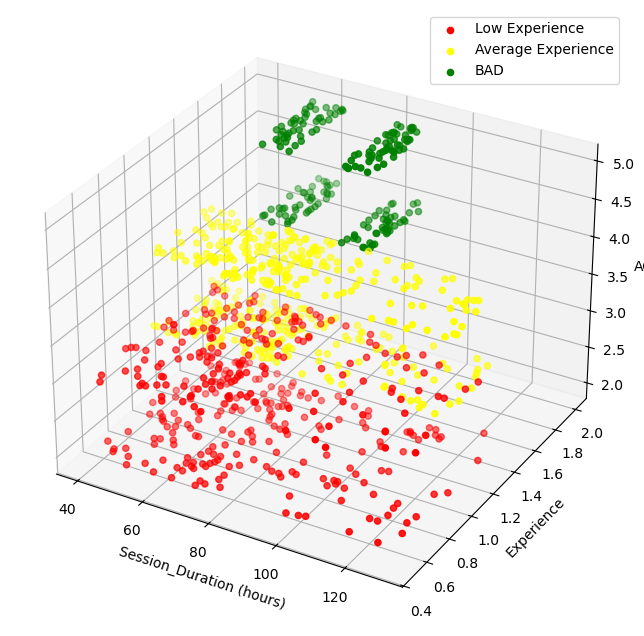

In [4]:
# Import the required libraries for data visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Create a 3D scatter plot
# Initialize a figure with a specific size for the 3D scatter plot.
fig = plt.figure(figsize=(10, 8))

# Add a 3D subplot to the figure
# '111' indicates 1x1 grid, first subplot. 'projection='3d'' is used to create a 3D projection.
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df[df['Experience_Level'] == 1]['Weight (kg)'],
           df[df['Experience_Level'] == 1]['Session_Duration (hours)'],
           df[df['Experience_Level'] == 1]['Workout_Frequency (days/week)'],
           c='red', label='Low Experience')
ax.scatter(df[df['Experience_Level'] == 2]['Weight (kg)'],
           df[df['Experience_Level'] == 2]['Session_Duration (hours)'],
           df[df['Experience_Level'] == 2]['Workout_Frequency (days/week)'],
           c='yellow', label='Average Experience')
ax.scatter(df[df['Experience_Level'] == 3]['Weight (kg)'],
           df[df['Experience_Level'] == 3]['Session_Duration (hours)'],
           df[df['Experience_Level'] == 3]['Workout_Frequency (days/week)'],
           c='green', label='BAD')

# Step 3: Set labels and legend
# Adding axis labels and a legend to make the plot more informative.
ax.set_ylabel('Experience')
ax.set_xlabel('Session_Duration (hours)')
ax.set_zlabel('AGE')
ax.legend()

# Display the plot
plt.show()

# Data Scaling
Through our experimentation with clustering, we found that using the data in its original form caused a lot of inaccuracy in our prediction, and would put too much emphisis on a few specific features.

Features include Calories, which caused significant discrepancies in the clusters. These columns have such a high variance and mean that they would skew the clusters, with their large numeric values, they would cause the clusters to center mostly on these features, rather than providing possible insights into other aspects of the data.

We attempted both Min-Max Scaling and Standardization with our combinations of model parameters, and concluded that standardization provided us a better overall performance, with a higher average silohette score



In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Feature Selection:
We selected 4 primary features to focus on.

These were primarily selected based on their relevance to our proposed business problem and ease of collection.

Since we are looking to gain insights into what the gym could provide and demographics to target their advertising better, this dataset includes a lot of unnecessary features. Another concern we had was with the collection of new data samples. Features like resting and average heart rate, or body fat percentage, would be extremely hard to collect with regularity from the customers of the gym. To reduce this, we hand-selected only the most relevant features, ensuring to stay within the realm of collectable. This gave us the following list: Weight (kg), Session_Duration (hours), Workout_Frequency (days/week), Experience_Level and Age.

The final problem with this slimmed dataset was posed by the Age feature. This feature was almost perfectly distributed among all clusters, regardless of the state of any of the Hyperparameters, mostly due to is low correlation to all other features. Since it did not add any useful information to our model, we elected to remove it to save on compute costs. 

In [6]:
# Step 3: Select Relevant Features
# For clustering, we focus on the features
# These features are selected and retained in the DataFrame for further processing.
df = df[['Weight (kg)', 'Session_Duration (hours)', 'Workout_Frequency (days/week)','Experience_Level']]

# Step 4: Convert Data for Machine Learning
# Convert the selected DataFrame into a NumPy array of type 'float32'.
# This conversion is necessary as most machine learning frameworks work efficiently with NumPy arrays.
data_np = df.values.astype('float32')

# Step 5: Save and Upload Preprocessed Data
# Save the preprocessed dataset to a CSV file, without the index.
# This file is then uploaded to an S3 bucket, making it accessible for machine learning tasks in SageMaker.
df.to_csv('test_gym.csv', index=False)
data_uri = sagemaker_session.upload_data('test_gym.csv', key_prefix=prefix)

# Output the S3 URI of the uploaded dataset for reference, confirming the successful upload.
print(f"Data uploaded to S3: {data_uri}")

# Finally, display the first few rows of the processed dataset to verify the preprocessing steps.
print(df.head())

Data uploaded to S3: s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/test_gym.csv
   Weight (kg)  Session_Duration (hours)  Workout_Frequency (days/week)  \
0     0.681493                  1.264598                       0.743295   
1     0.049316                  0.127098                       0.743295   
2    -0.271491                 -0.427068                       0.743295   
3    -0.974433                 -1.943735                      -0.352502   
4    -1.309393                 -1.797902                      -0.352502   

   Experience_Level  
0          1.609784  
1          0.257176  
2          0.257176  
3         -1.095432  
4         -1.095432  


# KMeans Model Training

In [7]:
# Define the range of k values for the KMeans clustering
# This range will determine how many models we train, each with a different number of clusters.
k_values = range(2, 8)

# Initialize lists to keep track of the S3 paths for the trained models and their training job names.
model_paths = []
training_jobs = []

# Set the output path in the S3 bucket for the trained models
# This path will be used to store the output (model artifacts) of each training job.
output_path = f's3://{sagemaker_session.default_bucket()}/sagemaker/kmeans-all/output'

# Iterate over each k value to train a separate KMeans model for that number of clusters
for k in k_values:
    # Generate a unique job name for each training job based on the k value
    job_name = f'kmeans-all-k-{k}'
    
    # Initialize the KMeans estimator from SageMaker with the specific k value
    # Configuration includes instance type, number of instances, and the specified k value.
    kmeans = KMeans(
        sagemaker_session=sagemaker_session,
        role=role,
        instance_count=1,
        instance_type='ml.m5.large',
        k=k,
        output_path=output_path,
        job_name=job_name,
        feature_dim=4  # Specify the number of features in the input data
    )
    
    # Start the training job for the KMeans model
    # We use 'wait=False' to start each training job asynchronously.
    kmeans.fit(kmeans.record_set(data_np), wait=False)
    training_jobs.append((k, kmeans.latest_training_job.name))

# After initiating all training jobs, we wait for each to complete and collect their model URIs
for k, job_name in training_jobs:
    # Wait for the completion of the training job
    sagemaker_client.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    
    # Retrieve the S3 URI of the model artifacts for the completed training job
    training_job_description = sagemaker_client.describe_training_job(TrainingJobName=job_name)
    model_s3_uri = training_job_description['ModelArtifacts']['S3ModelArtifacts']
    model_paths.append((k, model_s3_uri))

# Print the S3 paths of the model artifacts for all trained models
# This provides a clear reference to the location of each model for further analysis or deployment.
headers = ['k Value', 'S3 Model Artifact Path']
print(tabulate(model_paths, headers=headers))

[03/28/25 13:33:05] INFO     Same images used for training and inference. Defaulting to image     ]8;id=677662;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=994885;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=610642;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=123747;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=910331;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=654315;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=847457;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=109839;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-28-13-33-05-487        ]8;id=646447;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=144405;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/28/25 13:33:06] INFO     Same images used for training and inference. Defaulting to image     ]8;id=505497;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=482620;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=856016;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=761325;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=435834;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=391135;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=788901;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=441481;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-28-13-33-06-367        ]8;id=746604;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=143634;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/28/25 13:33:07] INFO     Same images used for training and inference. Defaulting to image     ]8;id=759487;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=306067;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=921266;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=65271;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=582115;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=253391;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=337260;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=726407;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-28-13-33-07-249        ]8;id=49024;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=285347;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/28/25 13:33:08] INFO     Same images used for training and inference. Defaulting to image     ]8;id=670288;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=784061;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=851290;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=707147;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=67919;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=51155;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=999953;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=421048;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-28-13-33-08-315        ]8;id=627802;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=844398;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/28/25 13:33:09] INFO     Same images used for training and inference. Defaulting to image     ]8;id=874209;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=482244;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=96514;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=582684;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=280464;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=545370;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

[03/28/25 13:33:10] INFO     Ignoring unnecessary instance type: None.                            ]8;id=391743;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=864259;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-28-13-33-09-669        ]8;id=540834;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=715295;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/28/25 13:33:11] INFO     Same images used for training and inference. Defaulting to image     ]8;id=222363;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=990105;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=155807;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=181537;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=402392;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=178405;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=585425;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=664702;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-28-13-33-11-154        ]8;id=295722;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=317878;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

  k Value  S3 Model Artifact Path
---------  --------------------------------------------------------------------------------------------------------------------
        2  s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/output/kmeans-2025-03-28-13-33-05-487/output/model.tar.gz
        3  s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/output/kmeans-2025-03-28-13-33-06-367/output/model.tar.gz
        4  s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/output/kmeans-2025-03-28-13-33-07-249/output/model.tar.gz
        5  s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/output/kmeans-2025-03-28-13-33-08-315/output/model.tar.gz
        6  s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/output/kmeans-2025-03-28-13-33-09-669/output/model.tar.gz
        7  s3://sagemaker-us-east-1-625293051840/sagemaker/kmeans-all/output/kmeans-2025-03-28-13-33-11-154/output/model.tar.gz


# Determine K through Elbow Plot

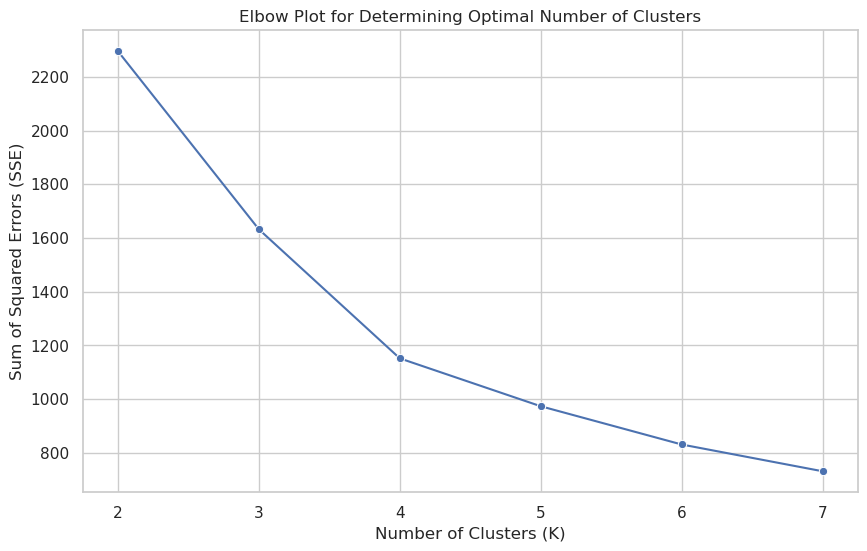

In [8]:
# List to store the Sum of Squared Errors (SSE) for each value of K
sse_values = []

# Iterate over each trained model's path to calculate SSE
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)
        
        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()
        
        # Calculate distances from each point to each centroid
        distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        
        # Calculate SSE for this value of K
        sse = np.sum((data_np - centroids[closest_centroids])**2)
        sse_values.append(sse)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Create and display the Elbow Plot using seaborn and matplotlib
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=[k for k, _ in model_paths], y=sse_values, marker='o')
plt.title('Elbow Plot for Determining Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks([k for k, _ in model_paths])
plt.show()

# Determine K through using Silhouette Method

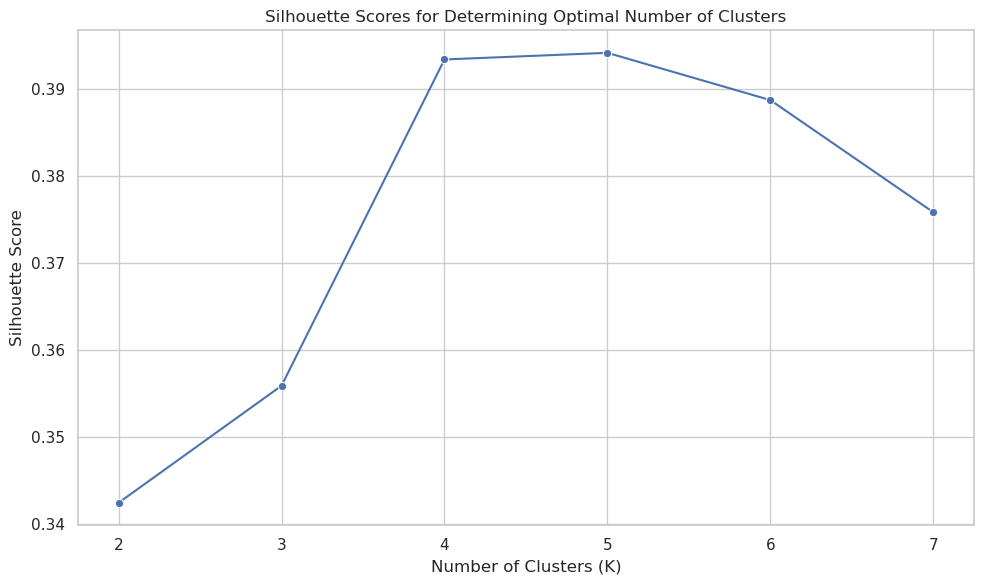

In [9]:
# List to store the silhouette scores for each value of K
silhouette_scores = []

# Iterate over each trained model's path to calculate its silhouette score
for k, model_path in model_paths:
    try:
        # Download the model artifacts from S3
        local_path = f'/tmp/model-k-{k}.tar.gz'
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)
        
        # Extract the model artifacts
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = kmeans_model_params[0].asnumpy()
        
        # Calculate distances from each point to each centroid
        distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
        
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        
        # Calculate the silhouette score for this value of K
        silhouette_score_value = silhouette_score(data_np, closest_centroids)
        silhouette_scores.append(silhouette_score_value)
    except Exception as e:
        print(f'Error processing model for K={k}: {e}')

# Plot the silhouette scores for different values of K, if available
if silhouette_scores:  # Ensure the list is not empty
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=[k for k, _ in model_paths], y=silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Determining Optimal Number of Clusters')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()  # Adjust the layout to make sure everything fits without overlap
    plt.show()
else:
    print("No silhouette scores to plot.")


# Selection of Ideal K

From the silhouette score it is very evident that the ideal number of clusers is either 4 or 5. With a silhouette score of almost 0.4 for each, and being basically identical, we can deduce that our clusters are statistically significant and both 4 or 5 could be ideal. Referencing the elbow test, it can be observed that there is a more distinct elbow at k =4, which would imply that 4 is more ideal. Considering our business application, we can deduce that a smaller k value would likely be better, as it would reduce computational costs. Therefore, the optimal value of k is 4.

# Visualize the centroids for the optimal K value and display the cluster assignments for each datapoint

/tmp/ipykernel_9663/1914821203.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap("tab10", best_k)  # Use a categorical colormap


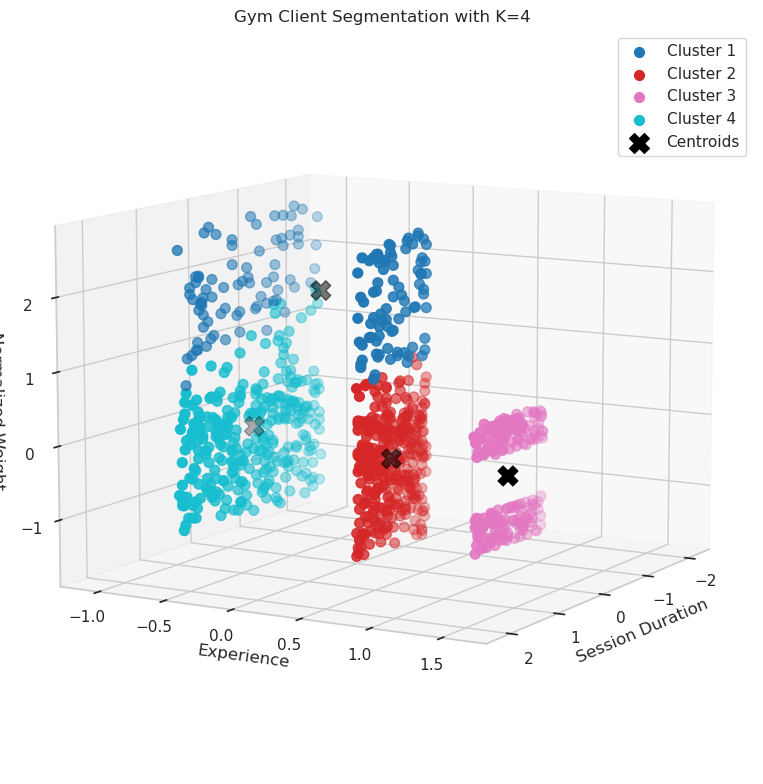

In [10]:
# Specify the optimal number of clusters determined previously
best_k = 4

# Retrieve the model path for the best K value from the list of trained models
best_model_path = next(path for k, path in model_paths if k == best_k)

# Download the best model artifacts from S3
local_path = f'/tmp/model-k-{best_k}.tar.gz'
s3_client.download_file(bucket, best_model_path.replace(f's3://{bucket}/', ''), local_path)

# Extract the model artifacts
with tarfile.open(local_path) as tar:
    tar.extractall(path=f'/tmp/k-{best_k}')

# Load the KMeans model parameters from the extracted files
kmeans_model_params = mx.ndarray.load(f'/tmp/k-{best_k}/model_algo-1')
centroids = kmeans_model_params[0].asnumpy()

# Calculate distances from each point to the centroids and determine closest centroid for each point
distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
closest_centroids = np.argmin(distances, axis=0)

# Initialize a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Set the number of points to sample per cluster
# sample_size = 100  # Adjust as needed

# Define a colormap for consistent cluster colors
cluster_colors = plt.cm.get_cmap("tab10", best_k)  # Use a categorical colormap
# colors = np.where(cluster_points[:, 16] == 1, 'blue', 
#                   np.where(cluster_points[:, 16] == 2, 'red', 'green'))

# Plot data points, color-coded by cluster assignment
for i in range(best_k):
    cluster_points = data_np[closest_centroids == i]
    # If the cluster has more points than the sample size, randomly select a subset
    # if len(cluster_points) > sample_size:        
    # Use the colormap to assign colors for each cluster
    cluster_color = cluster_colors(i / best_k)  # Get color for this cluster based on index
    ax.scatter(cluster_points[:, 1], cluster_points[:, 3], cluster_points[:, 0], 
               s=50, color=cluster_color, label=f'Cluster {i+1}')

# Plot centroids
ax.scatter(centroids[:, 1], centroids[:, 3], centroids[:, 0], 
           s=200, c='black', marker='X', label='Centroids')

# print(centroids)

# Customize the view angle for better visualization
ax.view_init(elev=10, azim=30)

# Set titles and labels
ax.set_title(f'Gym Client Segmentation with K={best_k}')
ax.set_xlabel('Session Duration')
ax.set_ylabel('Experience')
ax.set_zlabel('Normalized Weight')
ax.legend()

plt.tight_layout()
plt.show()

In [11]:
# Assuming `df` contains the original dataset and `kmeans.labels_` are the cluster assignments
df['cluster'] = closest_centroids

# Calculate the mean of each feature per cluster
cluster_means = df.groupby('cluster').mean()

# Display the cluster-wise means
print("Cluster Feature Means:\n", cluster_means)

# Optional: Check feature distribution in each cluster
for col in df.columns[:-1]:  # Exclude 'cluster' column from iteration
    print(f"\nFeature: {col}")
    print(df.groupby('cluster')[col].describe())  # Get distribution stats

Cluster Feature Means:
          Weight (kg)  Session_Duration (hours)  Workout_Frequency (days/week)  \
cluster                                                                         
0           1.738467                 -0.290127                      -0.365865   
1          -0.434480                 -0.021097                       0.248309   
2          -0.019944                  1.466627                       1.328485   
3          -0.477546                 -0.760177                      -0.920693   

         Experience_Level  
cluster                    
0               -0.394385  
1                0.257176  
2                1.609784  
3               -1.095432  

Feature: Weight (kg)
         count      mean       std       min       25%       50%       75%  \
cluster                                                                      
0        164.0  1.738467  0.536891  0.478630  1.339617  1.700524  2.221834   
1        321.0 -0.434480  0.590873 -1.597175 -0.898950 -0.403587 

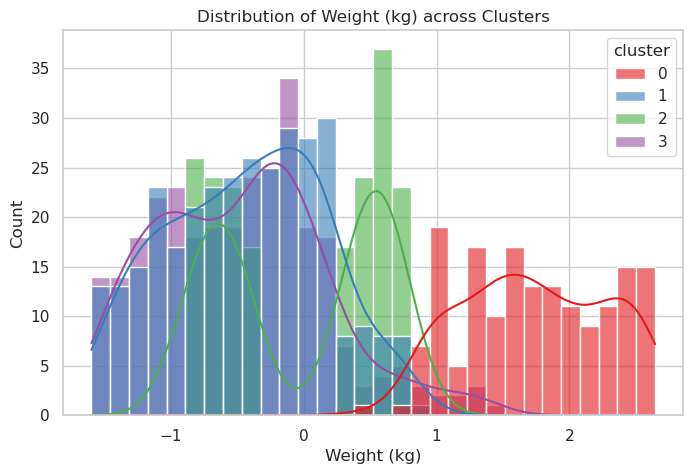

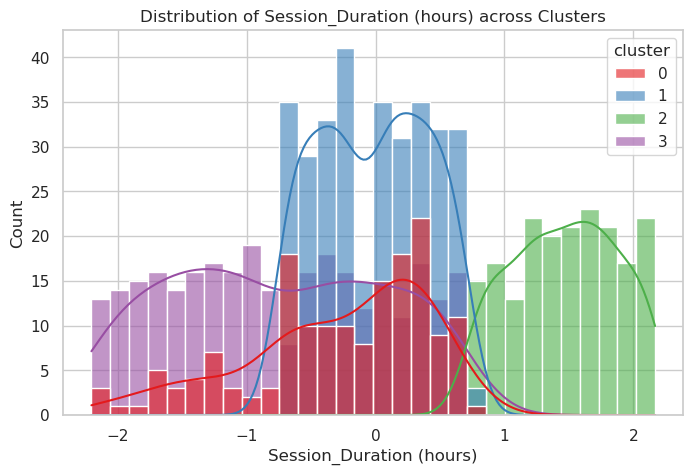

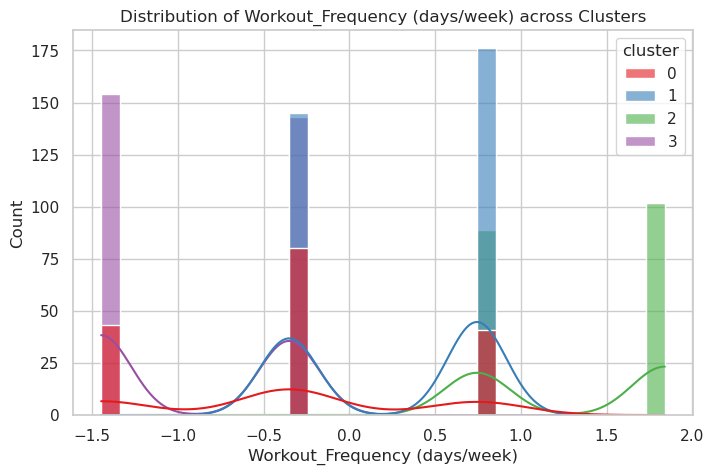

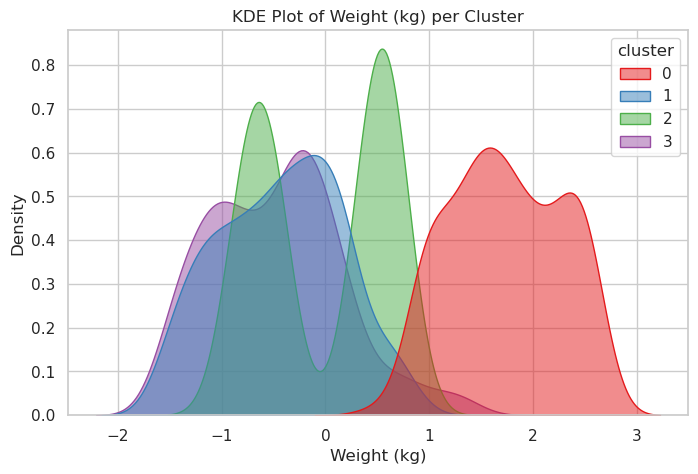

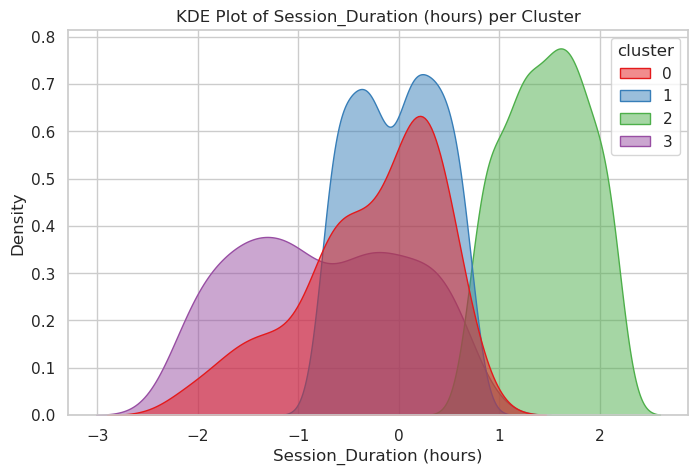

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your dataset and 'cluster' is the assigned cluster column
# Replace 'df' with your actual DataFrame name

features_to_plot = ['Weight (kg)', 'Session_Duration (hours)', 'Workout_Frequency (days/week)']
# Histograms for feature distributions
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=feature, hue='cluster', kde=True, bins=30, palette='Set1', alpha=0.6)
    plt.title(f'Distribution of {feature} across Clusters')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

# Box plots to show the spread of data within each cluster
# for feature in features_to_plot:
#     plt.figure(figsize=(8, 5))
#     sns.boxplot(data=df, x='cluster', y=feature, palette='Set2')
#     plt.title(f'Boxplot of {feature} per Cluster')
#     plt.xlabel('Cluster')
#     plt.ylabel(feature)
#     plt.show()

# KDE plots to visualize the density
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=feature, hue='cluster', fill=True, common_norm=False, palette='Set1', alpha=0.5)
    plt.title(f'KDE Plot of {feature} per Cluster')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()

# Model Deployment to SageMaker Endpoint

In [ ]:
# Specify names for the endpoint and its configuration
endpoint_name = 'kmeans-all'
endpoint_config_name = 'kmeans-all'

# Function to wait for endpoint configuration deletion
def wait_for_endpoint_config_deletion(endpoint_config_name):
    print(f'Waiting for endpoint configuration "{endpoint_config_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
                break
            else:
                raise

# Check and delete the existing endpoint configuration if it exists
try:
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    wait_for_endpoint_config_deletion(endpoint_config_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')

# Function to wait for endpoint deletion
def wait_for_endpoint_deletion(endpoint_name):
    print(f'Waiting for endpoint "{endpoint_name}" to be deleted...')
    while True:
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            time.sleep(5)  # Poll every 5 seconds
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" deleted.')
                break
            else:
                raise

# Check and delete the existing endpoint if it exists
try:
    sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    wait_for_endpoint_deletion(endpoint_name)
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint "{endpoint_name}" does not exist.')

# Identify the best model based on prior analysis
best_model_s3_uri = next(path for k, path in model_paths if k == best_k)

# Create a SageMaker Model object with the best model's artifacts
best_model = Model(
    model_data=best_model_s3_uri,
    image_uri=image_uri,
    role=role,
    sagemaker_session=sagemaker_session
)

# Deploy the model to an endpoint
# Note: This operation can take several minutes to complete.
predictor = best_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

print(f'Model deployed to endpoint: {endpoint_name}')

# Cluster Associations and Centroids

In [ ]:
from collections import Counter
from sklearn.metrics import confusion_matrix
# Extract true labels (0 = negative, 1 = positive)
true_labels = data_np[:, 0].astype(int)  # Ensure integer type

# Identify unique clusters
clusters = np.unique(closest_centroids)

# Map clusters to actual labels using majority voting
cluster_to_label = {}

for cluster in clusters:
    indices = np.where(closest_centroids == cluster)[0]
    majority_label = Counter(true_labels[indices]).most_common(1)[0][0]
    cluster_to_label[cluster] = majority_label

# Convert predicted clusters to their assigned labels
predicted_labels = np.array([cluster_to_label[c] for c in closest_centroids])

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

In [ ]:
# Initialize a Predictor object for the deployed SageMaker endpoint
predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())

def get_user_input(prompt):
    """Function to get user input; allows quitting by typing 'quit'."""
    user_input = input(prompt).strip()
    if user_input.lower() == 'quit':
        return None
    return user_input

def validate_and_prompt(feature_name, feature_prompt):
    """Validate and repeatedly prompt until a valid input or 'quit' is entered."""
    while True:
        user_input = get_user_input(feature_prompt)
        if user_input is None:  # User chose to exit
            return None
        try:
            value = float(user_input)
            if value > 0:
                return str(value)
            else:
                print(f"Please enter a positive number for {feature_name}.")
        except ValueError:
            print(f"Invalid input. Please enter a number for {feature_name}.")

print("Cluster Prediction Program")
print("Enter the following information for a prediction, or type 'quit' to exit.")

while True:
    # Collect inputs from the user
    #[['Weight (kg)', 'Session_Duration (hours)', 'Workout_Frequency (days/week)','Experience_Level']]
    weight = validate_and_prompt('Weight (kg)', "Enter Weight (kg):")
    if weight is None: break
    duration = validate_and_prompt('Session_Duration (hours)', "Enter Session Duration: ")
    if duration is None: break
    freq = validate_and_prompt('Workout_Frequency (days/week)', "Enter Workout Frequency: ")
    if freq is None: break
    level = validate_and_prompt('Experience_Level', "Enter Experience level: ")
    if level is None: break

# Prepare the data for prediction
    data = f'{weight},{duration},{freq},{level}\n'



    # Make prediction
    try:
        response = predictor.predict(data)
        # Parse the prediction response
        response_json = json.loads(response)
        cluster = response_json['predictions'][0]['closest_cluster']
        distance = response_json['predictions'][0]['distance_to_cluster']
        # Print the cluster assignment
        print(f"The data point belongs to Cluster {int(cluster)} with a distance of {distance:.2f} to the cluster center.")
    except Exception as e:
        print(f"An error occurred during prediction: {str(e)}")
    
    print("Program exited.")

# Delete the Endpoint and Endpoint Config

In [ ]:
# Prompt for confirmation before proceeding with the deletion
confirmation = input("Are you sure you want to delete the endpoint and endpoint configuration? (yes/no): ")

if confirmation.lower() == 'yes':

    # Function to delete endpoint configuration
    def delete_endpoint_config(endpoint_config_name):
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            print(f'Endpoint configuration "{endpoint_config_name}" exists. Deleting...')
            sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
            print(f'Endpoint configuration "{endpoint_config_name}" deleted successfully.')
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
            else:
                raise

    # Function to delete the endpoint
    def delete_endpoint(endpoint_name):
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            print(f'Endpoint "{endpoint_name}" exists. Deleting...')
            sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
            print(f'Endpoint "{endpoint_name}" deleted successfully.')
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" does not exist.')
            else:
                raise

    # Delete the endpoint configuration
    delete_endpoint_config(endpoint_config_name)

    # Delete the endpoint
    delete_endpoint(endpoint_name)

else:
    print("Deletion cancelled. The endpoint and its configuration were not deleted.")